# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

In [2]:
data=pd.read_csv('/datasets/faces/labels.csv')

In [3]:
data.head(5)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
data.shape[0]

7591

In [5]:
data.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [6]:
distr = data['real_age'].value_counts().sort_index().to_frame()

In [7]:
distr['by_5']=(distr.index//5)*5
distr=distr.groupby(by='by_5').sum()

In [9]:
datagen = ImageDataGenerator(rescale=1./255)
generator = datagen.flow_from_dataframe(data, '/datasets/faces/final_files', 
                                       x_col='file_name', y_col='real_age', 
                                       class_mode='raw')

Found 7591 validated image filenames.


Text(0, 0.5, 'count')

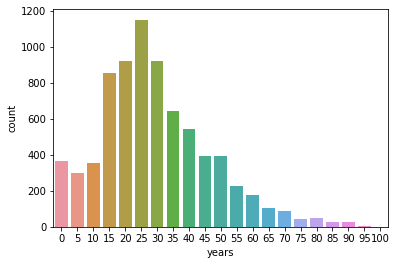

In [10]:
sns.barplot(x=distr.index, y="real_age", data=distr, ci=None)
plt.xlabel('years')
plt.ylabel('count')

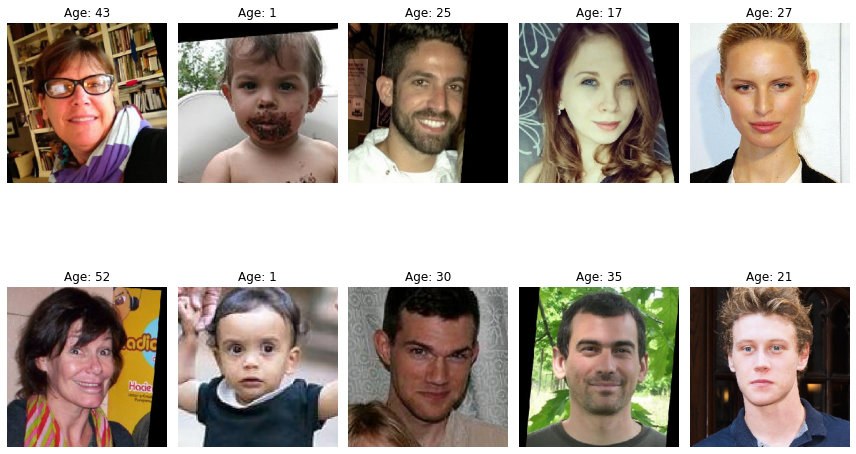

In [15]:
buffer = generator.next()
img=[]
fig = plt.figure(figsize=(12, 12))
for i in range(0,10):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(buffer[0][i])
    plt.title(f'Age: {buffer[1][i]}')
    plt.axis('off')
    plt.tight_layout()


Для решения задачи нам предоставлен большой датасет. Веса можно изменять. Данные имеют смещение с акцентом на возраст 20-40 лет. Модель может получить слабую предсказательную способность для больших возрастов. Учитывая размер данные для обучения лучше подавать батчами во избежании переполнения памяти, поток данных будет устроен из папки по разметке из csv файла. Для тестирвания выделим 25% датасета. 

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Flatten, Dense, AvgPool2D, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd


def load_data(path, subset):
    datagen = ImageDataGenerator(rescale = 1/255, validation_split=0.25)
    data=pd.read_csv(path+'labels.csv')
    flow = datagen.flow_from_dataframe(data, path+'/final_files', 
                                       x_col='file_name', y_col='real_age', 
                                       class_mode='raw',
                                       target_size=(224, 224),
                                       batch_size=16,
                                       subset=subset,
                                       seed=12345)
    return flow

def load_train(path):
    train_datagen_flow = load_data(path, 'training')
    return  train_datagen_flow

def load_test(path):
    test_datagen_flow = load_data(path, 'validation')
    return  test_datagen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                      weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                      include_top=False)


    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))


    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=optimizer, metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=12,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

In [ ]:
res = '''
<class 'keras.engine.sequential.Sequential'>
Epoch 1/12
 - 81s - loss: 10.6315 - mae: 10.6311 - val_loss: 23.3798 - val_mae: 21.6672
Epoch 2/12
 - 56s - loss: 7.4059 - mae: 7.4065 - val_loss: 12.0988 - val_mae: 9.3006
Epoch 3/12
 - 55s - loss: 6.2967 - mae: 6.2967 - val_loss: 18.1480 - val_mae: 7.9726
Epoch 4/12
 - 56s - loss: 5.5425 - mae: 5.5430 - val_loss: 6.6793 - val_mae: 6.6786
Epoch 5/12
 - 56s - loss: 4.9536 - mae: 4.9538 - val_loss: 7.5025 - val_mae: 7.8578
Epoch 6/12
 - 56s - loss: 4.4014 - mae: 4.4007 - val_loss: 5.9543 - val_mae: 6.2034
Epoch 7/12
 - 56s - loss: 4.0253 - mae: 4.0243 - val_loss: 6.6316 - val_mae: 6.5244
Epoch 8/12
 - 56s - loss: 3.6987 - mae: 3.6985 - val_loss: 3.4471 - val_mae: 6.3133
Epoch 9/12
 - 60s - loss: 3.3951 - mae: 3.3954 - val_loss: 4.2036 - val_mae: 5.9730
Epoch 10/12
 - 58s - loss: 3.1457 - mae: 3.1459 - val_loss: 7.3091 - val_mae: 6.2127
Epoch 11/12
 - 56s - loss: 3.0183 - mae: 3.0188 - val_loss: 5.6642 - val_mae: 6.0300
Epoch 12/12
 - 56s - loss: 2.8389 - mae: 2.8389 - val_loss: 8.2464 - val_mae: 6.5149
Test MAE: 6.5149
'''

## Анализ обученной модели

In [ ]:
import re
match = re.findall(r'[-+]?(?:\d+(?:\.\d*)?|\.\d+)', res)
mae = []
for i in range(3, len(match), 7):
    mae.append([float(match[i+1]), float(match[i+3])])
mae = pd.DataFrame(mae)

for col in mae.columns:
    plt.plot(mae[col], marker='o')
plt.legend(['train', 'test'])
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.show()    

В ходе работы была подготовлена ResNet50 модель и предварительно обученными весами. Модель получила хороший прирост качества за 5 эпох. Для обучения это будет оптимальное значение. Итогововый MAE модель поучила 6.5. Для лучшего результата можно применить детекцию лиц на изображении для обрезки лишней информации и аугментацию. Данная модель соответствует требованиям по качеству и может применятся для распознания примерного возраста покупателя при условии подачи на вход схожего с тренировочным датасетом изображения(лицо крупным планом).